In [1]:
from tqdm import tqdm

import matplotlib.pyplot as plt

import torch, torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

from utils import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [23]:
transform = transforms.Compose([
    transforms.Resize((360, 640)),
    transforms.ToTensor(),
])

dataset = torchvision.datasets.ImageFolder(images_path, transform= transform,
                                           is_valid_file= lambda x : cv2.imread(x) is not None)

In [24]:
batch_size = 64

train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [0.6, 0.2, 0.2])

train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True,
                                         drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size, shuffle=True,
                                         drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_ds)

In [2]:
class Net(nn.Module):

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.conv1 = nn.Conv2d(3, 6, kernel_size= 5, padding= 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size= 5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc0 = nn.LazyLinear(1024)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 2)


    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.flatten(X)
        X = F.relu(self.fc0(X))
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))

        return self.fc4(X)

net = Net()
net.to(device)

f:\GitHub Repos\day-night classifier\venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc0): LazyLinear(in_features=0, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
)

In [56]:
epochs = 8
lr = 0.001
optim = torch.optim.Adam(net.parameters(), lr=lr)

loss_fn = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

vaildation = True

for epoch in range(epochs):
    net.train()

    train_correct = 0
    train_loss = 0

    for X, y in tqdm(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        optim.zero_grad()

        pred = net(X)

        loss = loss_fn(pred, y)

        train_loss += loss.item() * X.size(0)
        pred = torch.argmax(pred, dim= -1)
        train_correct += (pred == y).float().sum()

        with torch.no_grad():
            loss.backward()
            optim.step()

    train_loss /= len(train_ds)
    train_losses.append(train_loss)

    train_accuracy = 100 * train_correct / len(train_ds)

    if not vaildation:
      print(f"Epoch: {epoch} Train loss: {train_loss:.4f} Train accuracy: {train_accuracy:.4f}")
      continue

    net.eval()

    val_correct = 0
    val_loss = 0

    for X, y in val_dataloader:
      X = X.to(device)
      y = y.to(device)

      pred = net(X)

      loss = loss_fn(pred, y)

      val_loss += loss.item() * X.size(0)
      pred = torch.argmax(pred, dim= -1)
      val_correct += (pred == y).float().sum()

    val_loss /= len(val_ds)
    val_losses.append(val_loss)

    val_accuracy = 100 * val_correct / len(val_ds)

    print(f"Epoch: {epoch} Train loss: {train_loss:.4f} Train accuracy: {train_accuracy:.4f}\t" \
           +f"Val loss: {val_loss:.4f} Val accuracy: {val_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 53/53 [02:04<00:00,  2.36s/it]


Epoch: 0 Train loss: 0.3513934788066069 Train accuracy: 88.04792022705078                            Val loss: 0.09597668187660083 Val accuracy: 93.15789794921875


100%|██████████| 53/53 [02:02<00:00,  2.31s/it]


Epoch: 1 Train loss: 0.01727555720542845 Train accuracy: 98.88953399658203                            Val loss: 0.03607046668205345 Val accuracy: 94.91228485107422


100%|██████████| 53/53 [02:02<00:00,  2.31s/it]


Epoch: 2 Train loss: 0.014282161720730647 Train accuracy: 98.80186462402344                            Val loss: 0.016297959314103713 Val accuracy: 95.08772277832031


100%|██████████| 53/53 [02:15<00:00,  2.56s/it]


Epoch: 3 Train loss: 0.006478013146493403 Train accuracy: 99.00642395019531                            Val loss: 0.014496620690650225 Val accuracy: 95.08772277832031


100%|██████████| 53/53 [02:11<00:00,  2.49s/it]


Epoch: 4 Train loss: 0.003994119871678 Train accuracy: 99.00642395019531                            Val loss: 0.010526832521549965 Val accuracy: 95.08772277832031


100%|██████████| 53/53 [02:07<00:00,  2.40s/it]


Epoch: 5 Train loss: 0.015058459553084599 Train accuracy: 98.83109283447266                            Val loss: 0.0204943464308152 Val accuracy: 95.1754379272461


100%|██████████| 53/53 [02:02<00:00,  2.31s/it]


Epoch: 6 Train loss: 0.006174162986502947 Train accuracy: 98.94798278808594                            Val loss: 0.012684123570981778 Val accuracy: 95.08772277832031


100%|██████████| 53/53 [02:02<00:00,  2.32s/it]


Epoch: 7 Train loss: 0.0013981408596050113 Train accuracy: 99.06487274169922                            Val loss: 0.011088784502077799 Val accuracy: 95.2631607055664


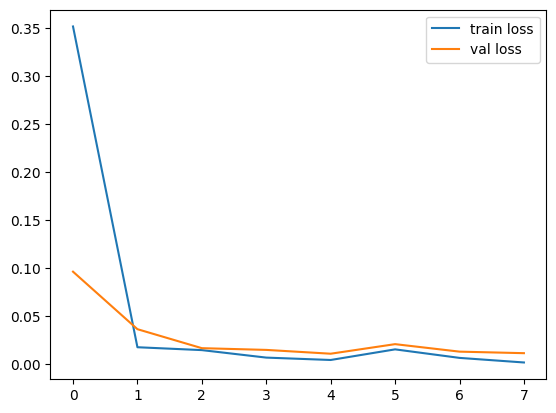

In [58]:
plt.plot(range(epochs), train_losses, val_losses)
plt.legend(['train loss', 'val loss'])

In [61]:
net.eval()

test_losses = []
test_correct = 0
test_loss = 0

for X, y in test_dataloader:
  X = X.to(device)
  y = y.to(device)

  pred = net(X)

  loss = loss_fn(pred, y)

  test_loss += loss.item() * X.size(0)
  pred = torch.argmax(pred, dim= -1)
  test_correct += (pred == y).float().sum()

test_loss /= len(val_ds)
test_losses.append(val_loss)

test_accuracy = 100 * test_correct / len(val_ds)

print(f"Test loss: {test_loss:.4f} Test accuracy: {test_accuracy:.4f}")

Test loss: 0.0007 Test accuracy: 100.0000


In [71]:
model_name = f"pytorch_model_{epochs=}_{batch_size=}_{lr=}_{train_loss=:.4f}.pt"
torch.save(net, f"./{model_name}")